In [1]:
######### PACKAGES ###########
# install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)
library(INLA)
setwd('/projects/ADE_biomass_harmonization/biomass_harmonization/NASA_CMS_2023/Mexico/FH-SAE_Mayetal/')
load("GEDI_HEX.RData")
load("TCC_HEX.RData")

Warning message:
“package ‘INLA’ was built under R version 4.3.1”
Loading required package: Matrix

Loading required package: sp

This is INLA_23.09.09 built 2023-10-16 17:29:11 UTC.
 - See www.r-inla.org/contact-us for how to get help.



In [5]:
###################
# Get the INLA model prepped
#####################

# Creates a mesh. Used within INLA to give a sparse representation of the spatial effects.
# For more info about the mesh, projection matrices, and the INLA approach to spatial effects, 
# see the 'SPDE Book',  https://becarioprecario.bitbucket.io/spde-gitbook/, Chapter 2
# For the paper results, we used the top mesh (commented out) with no cutoff on the mesh density.
# This mesh is very fine, and the mesh below it can be used with similar results
# and much half the computation time. But if you want the paper results 'exactly', use the first mesh.

#mesh = inla.mesh.2d(coord, max.edge = 2)
mesh = inla.mesh.2d(coord, max.edge = 2, cutoff = 0.5)


# Projection matrix for the spatial error/intercept, projecting the spatial effects on the mesh onto the actual coordinates
A.eta = inla.spde.make.A(mesh, coord)
 
# Projection matrices for the spatially varying coeffecients.
# Same as above, but weights the entries by the values of the predictors, GEDI and TCC (see weights = ...) 
# This multiplies the spatial effects by the predictors, creating the spatially varying regression coefficients.
A.G = inla.spde.make.A(mesh, coord, weights = GEDI)
A.T = inla.spde.make.A(mesh, coord, weights = TCC)

# Defines a Penalized Complexity prior on the spatial intercept (spde),
# and the spatially varying coefficient for TCC and GEDI (spdeT, spdeG).
# For example, spde declares that the prior probability of the spatial intercept standard error
# being greater than 2 is 0.1, while the prior probability of the range being less than 1 is 0.1
spde.eta = inla.spde2.pcmatern(mesh, prior.sigma = c(2,0.1), prior.range = c(1,0.1))
spde.T = inla.spde2.pcmatern(mesh, prior.sigma = c(20,0.1), prior.range = c(1,0.1))
spde.G = inla.spde2.pcmatern(mesh, prior.sigma = c(2,0.1), prior.range = c(1,0.1))

# Creates a data stack, which is how INLA organizes data (see Section 2.2.3 of the SPDE Book, link given previously)
# To give a short summary, the model response is given by 'data' (which we set at the HT estimates and call 'fia')
# The model effects (predictors, spatial effects, etc) are given by 'effects'
# and the projections for those effects are given by 'A'.
# The effects are left-multiplied by the corresponding projection in 'A',
# e.g., the 6th entry of effects 'eta' is multiplied by by the 6th entry of A, 'A.eta'.
# Note that effect 'delta' represents the sampling error, and is multiplied by a diagonal matrix
# with the HT standard errors as the diagonal. Effect 'delta' will have its standard deviation fixed to one (see below),
# so multiplying by the HT standard errors will give 'delta' a standard deviation equal to the HT standard errors.
# The spatial effects (eta, beta.G, beta.T) are defined on the mesh, but projected onto the coordinates with (A.eta, A.G, A.T)

# You can toy around with including/removing predictors and spatial effects
# by deleting the effects and their associated projections from the stack.
# You'll need to change the formula further below, too.

stack = inla.stack(
  data = list(fia = ht.hex),
  A = list(1, 1, 1, 1, Diagonal(x = htsd.hex), A.eta, A.G, A.T), #1,    , A.T
  effects = list(intercept = rep(1,n), 
                 TCC = TCC,
                 GEDI = GEDI,
                 epsilon = 1:n, 
                 delta = 1:n, 
                 eta = 1:spde.eta$n.spde,
                 beta.G = 1:spde.G$n.spde,
                 beta.T = 1:spde.T$n.spde)) 

# Fixes the standard deviation of the sampling error 'delta' to one.
# (defined the precision, which is the inverse variance, to be exp(0) = 1)
# 'delta' is multiplied by the HT standard errors in the stack above 
# to give the appropriate, assumed known, sampling variance.
delta.pars = list(prec = list(initial = 0, fixed  = T))
# R-INLA automatically adds random noise to the model. To suppress this, we fix
# the precision of the random noise to be exp(10), giving an insignificantly small variance.
# This is done because effect 'epsilon', defined in the stack, already serves as our random noise.
family.pars = list(prec = list(initial = 10, fixed  = T))

# Gives the model formula. The '-1' suppresses INLA's automatic inclusion of an intercept (we already have one)
f = fia ~ -1 + intercept + GEDI + TCC + 
  f(eta, model = spde.eta) + 
  f(beta.G, model = spde.G) +
  f(beta.T, model = spde.T) +
  f(epsilon, model = "iid") +
  f(delta, model = "iid", hyper = delta.pars)

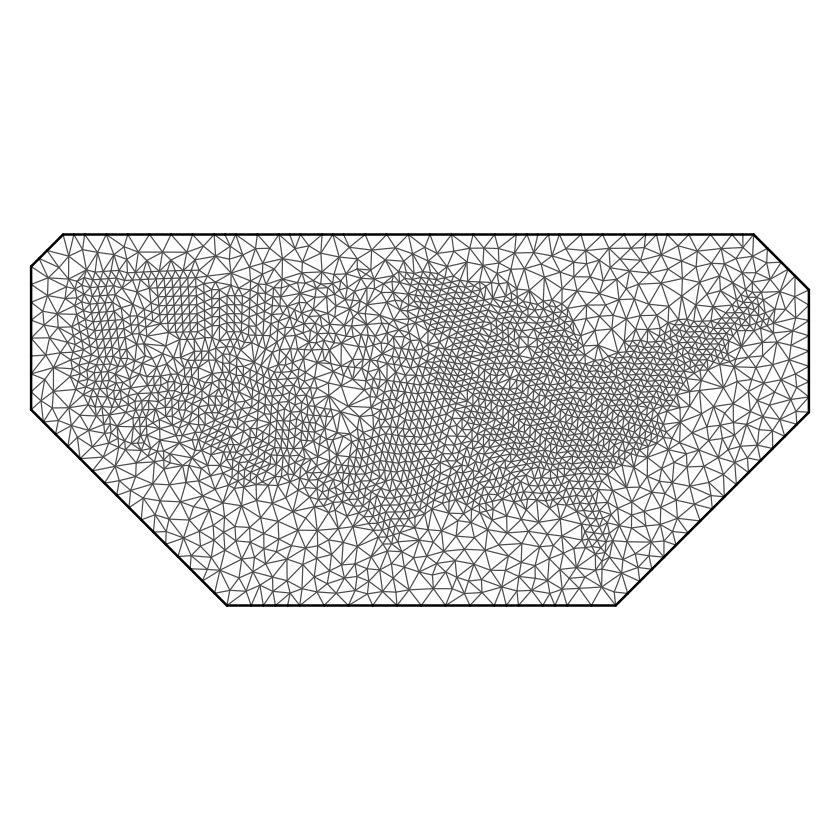

In [6]:
par(mar = c(0, 0, 0, 0))
plot(mesh, asp = 1, main = "")


Call:
   c("inla.core(formula = formula, family = family, contrasts = contrasts, 
   ", " data = data, quantiles = quantiles, E = E, offset = offset, ", " 
   scale = scale, weights = weights, Ntrials = Ntrials, strata = strata, 
   ", " lp.scale = lp.scale, link.covariates = link.covariates, verbose = 
   verbose, ", " lincomb = lincomb, selection = selection, control.compute 
   = control.compute, ", " control.predictor = control.predictor, 
   control.family = control.family, ", " control.inla = control.inla, 
   control.fixed = control.fixed, ", " control.mode = control.mode, 
   control.expert = control.expert, ", " control.hazard = control.hazard, 
   control.lincomb = control.lincomb, ", " control.update = 
   control.update, control.lp.scale = control.lp.scale, ", " 
   control.pardiso = control.pardiso, only.hyperparam = only.hyperparam, 
   ", " inla.call = inla.call, inla.arg = inla.arg, num.threads = 
   num.threads, ", " keep = keep, working.directory = working.directory,

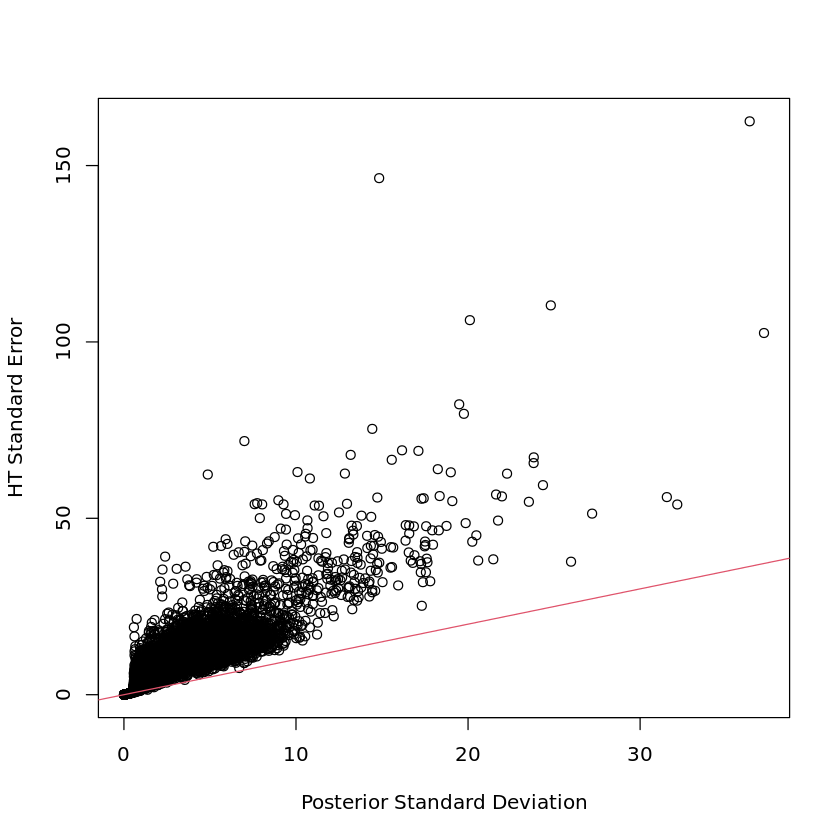

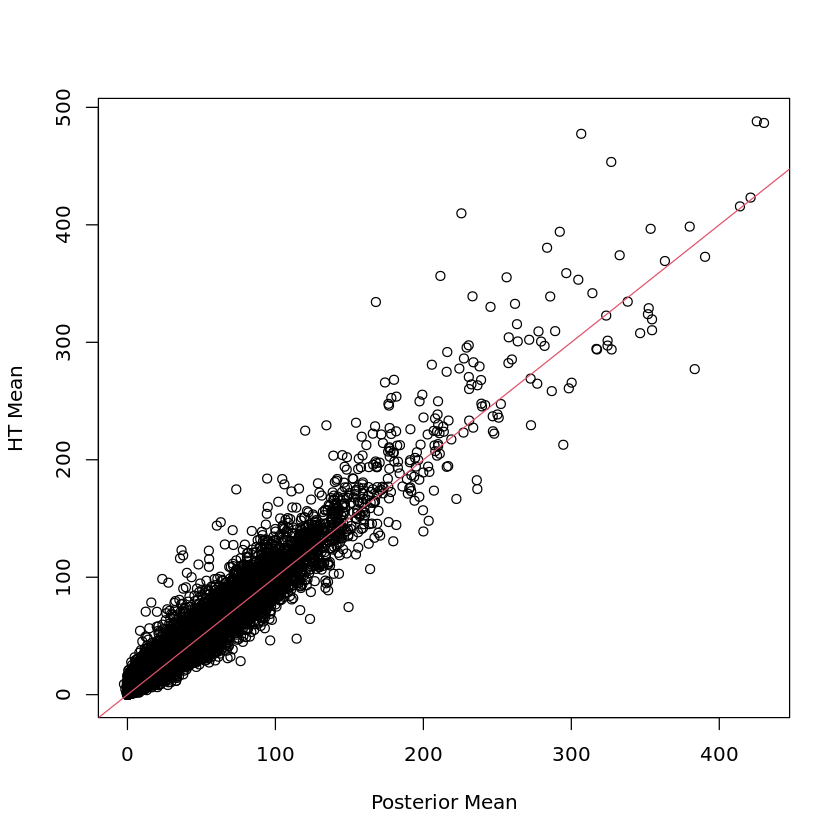

In [7]:
##############################
# Fit the model! 
# Depending on your machine, this might take a minute (36 minutes on my laptop). 
#############################

sae.mod = inla(f, family = "Gaussian", 
               data = inla.stack.data(stack),
               control.family = list(hyper = family.pars),
               control.predictor = list(A = inla.stack.A(stack)),
               control.inla = list(strategy = "gaussian"))

#################################
# Examining model results
##################################

# Quick print of the posterior parameter statistics
summary(sae.mod)

# Posterior mean and standard deviation of sampling error delta. 
# This is a quick and dirty way to get at the posterior means and standard deviation for mu_j,
# as \mu_j = \hat{\mu_j} - \delta_j, where \hat{\mu_j} is the HT (or some direct) estimate,
# Therefore E[\mu_j|data] =  \hat{\mu_j} - E[\delta_j|data] and Var[\mu_j|data] = Var[\delta_j|data].
delta.mu = htsd.hex*sae.mod$summary.random$delta$mean
delta.sd = htsd.hex*sae.mod$summary.random$delta$sd

# Posterior mean and standard deviation of mu_j

mu.predict = ht.hex - delta.mu
mu.sd = delta.sd

# A rendition of Figure 5 in the paper, comparing the means and uncertanties to the direct estimates.
plot(mu.sd, htsd.hex, xlab = "Posterior Standard Deviation", ylab = "HT Standard Error")
abline(a = 0, b = 1, col = 2)

plot(mu.predict, ht.hex, xlab = "Posterior Mean", ylab = "HT Mean")
abline(a = 0, b = 1, col = 2)


Call:
   c("inla.core(formula = formula, family = family, contrasts = contrasts, 
   ", " data = data, quantiles = quantiles, E = E, offset = offset, ", " 
   scale = scale, weights = weights, Ntrials = Ntrials, strata = strata, 
   ", " lp.scale = lp.scale, link.covariates = link.covariates, verbose = 
   verbose, ", " lincomb = lincomb, selection = selection, control.compute 
   = control.compute, ", " control.predictor = control.predictor, 
   control.family = control.family, ", " control.inla = control.inla, 
   control.fixed = control.fixed, ", " control.mode = control.mode, 
   control.expert = control.expert, ", " control.hazard = control.hazard, 
   control.lincomb = control.lincomb, ", " control.update = 
   control.update, control.lp.scale = control.lp.scale, ", " 
   control.pardiso = control.pardiso, only.hyperparam = only.hyperparam, 
   ", " inla.call = inla.call, inla.arg = inla.arg, num.threads = 
   num.threads, ", " keep = keep, working.directory = working.directory,

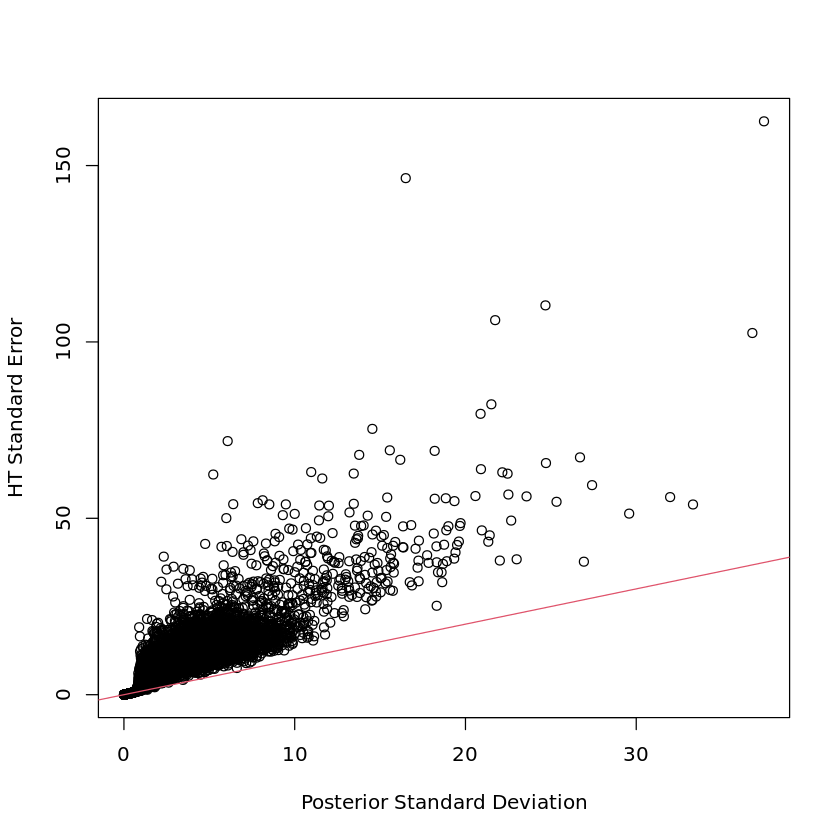

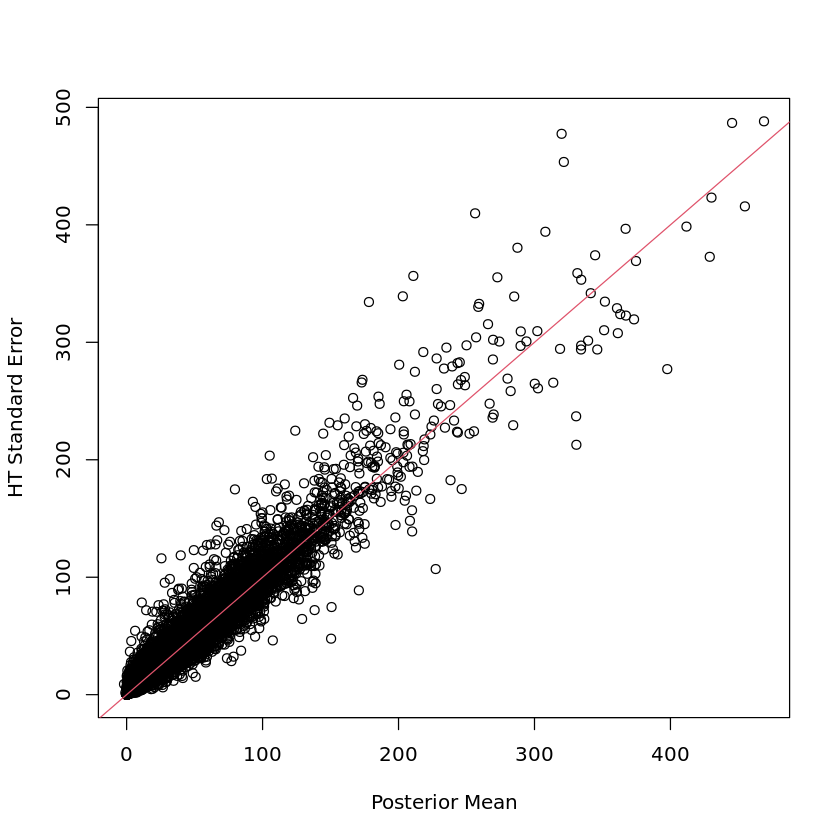

In [22]:
##############################
# Fit the model! 
# Depending on your machine, this might take a minute (36 minutes on my laptop). 
#############################

sae.mod = inla(f, family = "Gaussian", 
               data = inla.stack.data(stack),
               control.family = list(hyper = family.pars),
               control.predictor = list(A = inla.stack.A(stack)),
               control.inla = list(strategy = "gaussian"))

#################################
# Examining model results
##################################

# Quick print of the posterior parameter statistics
summary(sae.mod)

# Posterior mean and standard deviation of sampling error delta. 
# This is a quick and dirty way to get at the posterior means and standard deviation for mu_j,
# as \mu_j = \hat{\mu_j} - \delta_j, where \hat{\mu_j} is the HT (or some direct) estimate,
# Therefore E[\mu_j|data] =  \hat{\mu_j} - E[\delta_j|data] and Var[\mu_j|data] = Var[\delta_j|data].
delta.mu = htsd.hex*sae.mod$summary.random$delta$mean
delta.sd = htsd.hex*sae.mod$summary.random$delta$sd

# Posterior mean and standard deviation of mu_j

mu.predict = ht.hex - delta.mu
mu.sd = delta.sd

# A rendition of Figure 5 in the paper, comparing the means and uncertanties to the direct estimates.
plot(mu.sd, htsd.hex, xlab = "Posterior Standard Deviation", ylab = "HT Standard Error")
abline(a = 0, b = 1, col = 2)

plot(mu.predict, ht.hex, xlab = "Posterior Mean", ylab = "HT Mean")
abline(a = 0, b = 1, col = 2)

In [ ]:
# ############################
# # Cross-Validation Study
# ############################

# # This performs 10-fold cross-val, testing the hexes with n > 26 plots.
# # Since this fits the model 10 times, it'll take a while.

# n.folds = 10

# # Gets index for the hexes with > 26 plots
# bign.index = which(n.plots > 26)

# # How many of these hexes are there?
# n.big = length(bign.index)

# # Opens up vectors for instances of non-coverage (mod.fail),
# # the cross-val predictions (cv.p), and the cross val RMSE (cv.p.sd).
# mod.fail = cv.p = cv.p.sd = vector(, length = n.big)

# set.seed(96)

# # Randomly scrambles the test hexes to prevent geographic grouping in the cross-val.
# scramble = sample(bign.index, n.big)

# # Splits the data into folds
# folds = cut(1:n.big, breaks = n.folds, labels = F)

# # Begin the cross-val. Run this and then go take a long lunch.
# for(i in 1:n.folds){
  
#   # Print which fold we are on
#   print(i)
  
#   # Get the indices for the current test fold.
#   test.sample = scramble[folds == i]
  
#   # A temp vector for the direct estimates. Replace the test fold with NA. 
#   # INLA automatically predicts data values with NA.
#   # We don't NA the htsd.hex test fold, 
#   # because INLA needs these values to compute our credible intervals for the direct estimate.
  
#   ymu = ht.hex
#   ymu[test.sample] = NA
#   ysd = htsd.hex
  
#   # Same deal as before. Create a stack, but with the cross-val data.
#   cv.stack = inla.stack(
#     data = list(fia = ymu),
#     A = list(1, 1, 1, 1, Diagonal(x = ysd), A.eta, A.G, A.T), 
#     effects = list(intercept = rep(1,n), 
#                    GEDI = GEDI,
#                    TCC = TCC,
#                    epsilon = 1:n, 
#                    delta = 1:n, 
#                    eta = 1:spde.eta$n.spde,
#                    beta.G = 1:spde.G$n.spde,
#                    beta.T = 1:spde.T$n.spde)) 
  
  
#   cv.mod = inla(f, family = "Gaussian", 
#                 data = inla.stack.data(cv.stack),
#                 control.family = list(hyper = family.pars),
#                 control.predictor = list(A = inla.stack.A(cv.stack)),
#                 control.inla = list(strategy = "gaussian"))
  
#   # Print how much time was taken in seconds. Gives you an idea of the wait you're looking at.
#   print(cv.mod$cpu.used[4])
  
#   # Get the posterior mean and standard deviation for the test fold hexes.
#   p.mu = cv.mod$summary.fitted.values$mean[test.sample]
#   p.sd = cv.mod$summary.fitted.values$sd[test.sample]
  
#   # We approximate the posterior distribution quantiles with normal quantiles.
#   # Note that this is a VERY good approximation, because all the latent effects here are normal,
#   # but INLA also returns fitted quantiles that can be used instead (e.g. cv.mod$summary.fitted.values$`0.025quant`)
#   # The results will be indistinguishable for this application,
  
#   # Width of the credible interval
#   quants = qnorm(0.975, sd = p.sd)
  
#   # Which test hexes are not contained within the credible interval ?
#   mod.fail[folds == i] = abs(p.mu - ht.hex[test.sample]) > quants
#   # Save the posterior means and standard deviations
#   cv.p[folds == i] = p.mu
#   cv.p.sd[folds == i] = p.sd
  
  
# }


# ##################################
# # Some results from the cross-val
# ################################

# # Coverage
# 1 - mean(mod.fail)

# # Compare the model predictions to the test direct estimates across all folds. Rendition of Figure 6a.
# plot(cv.p, ht.hex[scramble], xlab = "Model Posterior Mean", ylab = "Test Direct Estimate")

# # qq-plot for coverage, like Figure 6b

# qqplot(ht.hex[!mod.fail], ht.hex, xlab = "Covered Direct Estimate Quantiles", ylab = "Test Direct Estimate Quantiles")